In [1]:
import numpy as np
from os import path as osp
import glob
import cv2
import matplotlib.pyplot as plt

from retrievalnet.settings import DATA_PATH
from utils import plot_imgs
from retrievalnet.datasets.utils.nclt_undistort import Undistort
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
seq = '2012-01-08'
#seq = '2013-04-05'
#seq = '2012-08-20'
cam = 'Cam4'

In [3]:
root = DATA_PATH+'datasets/nclt/'
gt_file = root+'groundtruth_{}.csv'.format(seq)
im_root = root+'{}/lb3/{}/'.format(seq, cam)
dumap_file = root+'undistort_maps/U2D_{}_1616X1232.txt'.format(cam)

In [4]:
gt_time, gt_x, gt_y, _, _, _, gt_angle = np.loadtxt(open(gt_file, "rb"), delimiter=",", skiprows=1).T
im_list = glob.glob(osp.join(im_root, '*.tiff'))
im_list = [osp.splitext(osp.split(i)[1])[0] for i in im_list]
im_list = sorted(im_list, key=lambda i: int(i))
im_list = im_list[5:] # drop first 5 frames
d2u = Undistort(dumap_file)

In [5]:
# Remove distortion mask
h, w = d2u.mask.shape
x_min, x_max = [f(np.where(d2u.mask[int(h/2), :])[0]) for f in [np.min, np.max]]
y_min, y_max = [f(np.where(d2u.mask[:, int(w/2)])[0]) for f in [np.min, np.max]]
def imread(name, undis=True):
    im = cv2.imread(im_root+name+'.tiff')
    if undis:
        im = d2u.undistort(im)[y_min:y_max, x_min:x_max, ...]
    return np.rot90(im, k=3)

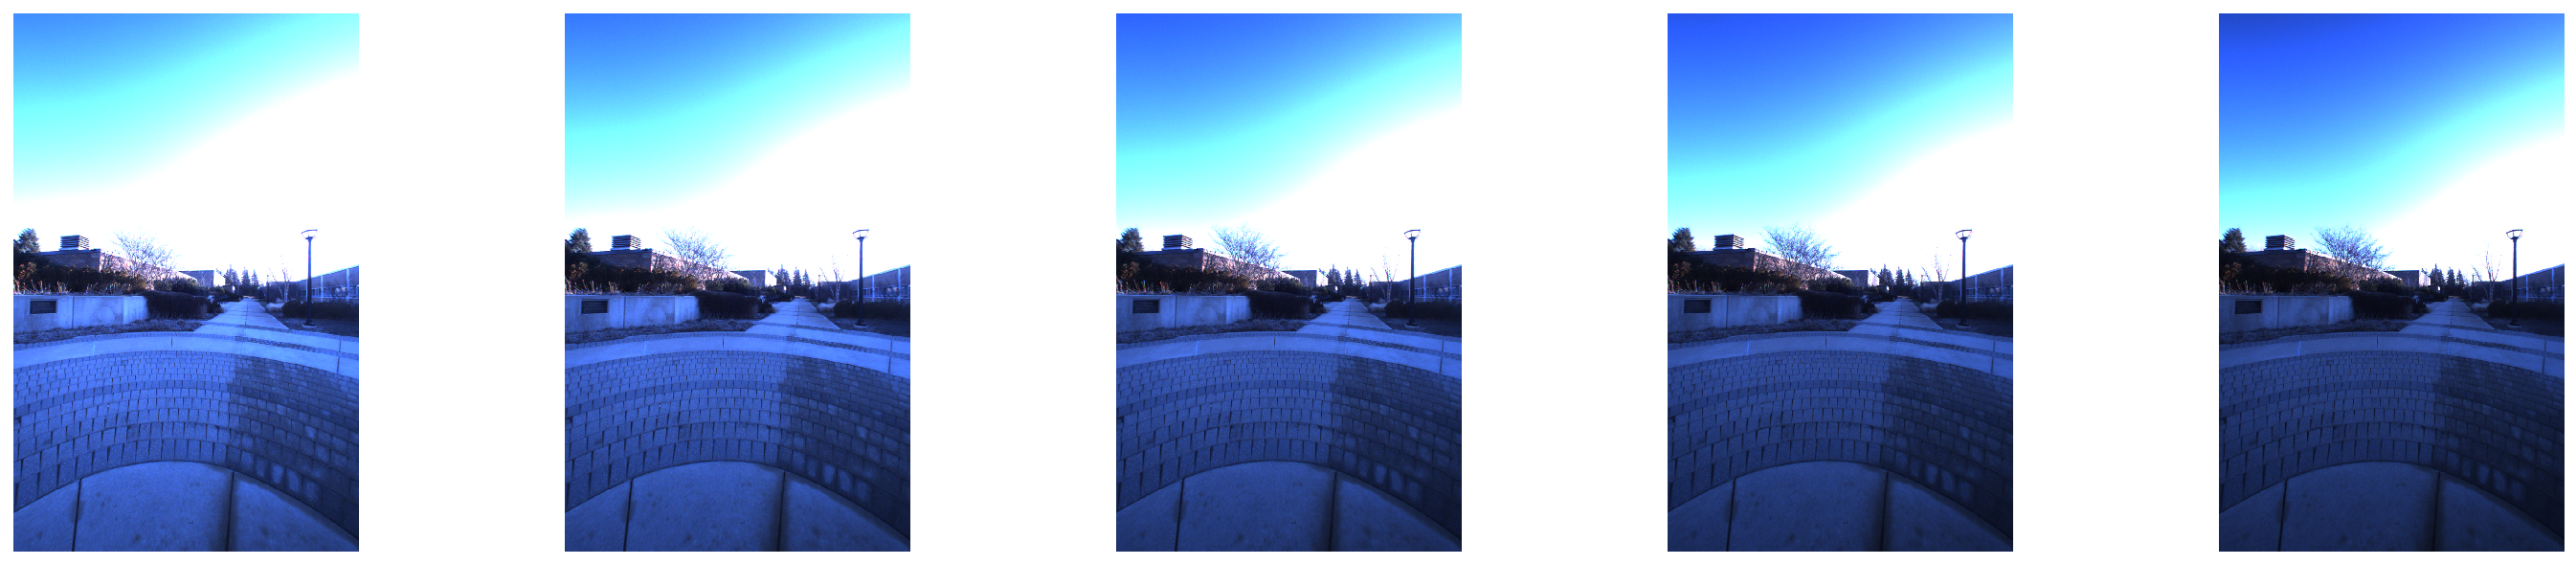

In [6]:
plot_imgs([imread(im_list[i]) for i in range(5)])

In [7]:
def find_nearest(array, value):
    return (np.abs(array-value)).argmin()

In [8]:
sampling_interval = 5 # meters
distance = np.cumsum(np.linalg.norm(np.subtract([gt_x[1:], gt_y[1:]], [gt_x[:-1], gt_y[:-1]]), axis=0))
keypoints = np.arange(np.max(distance), step=sampling_interval)
gt_idx = [find_nearest(distance, k) for k in keypoints]
im_idx = [find_nearest([int(im) for im in im_list], gt_time[i]) for i in gt_idx]
print('Number of samples: {}'.format(len(keypoints)))

Number of samples: 1300


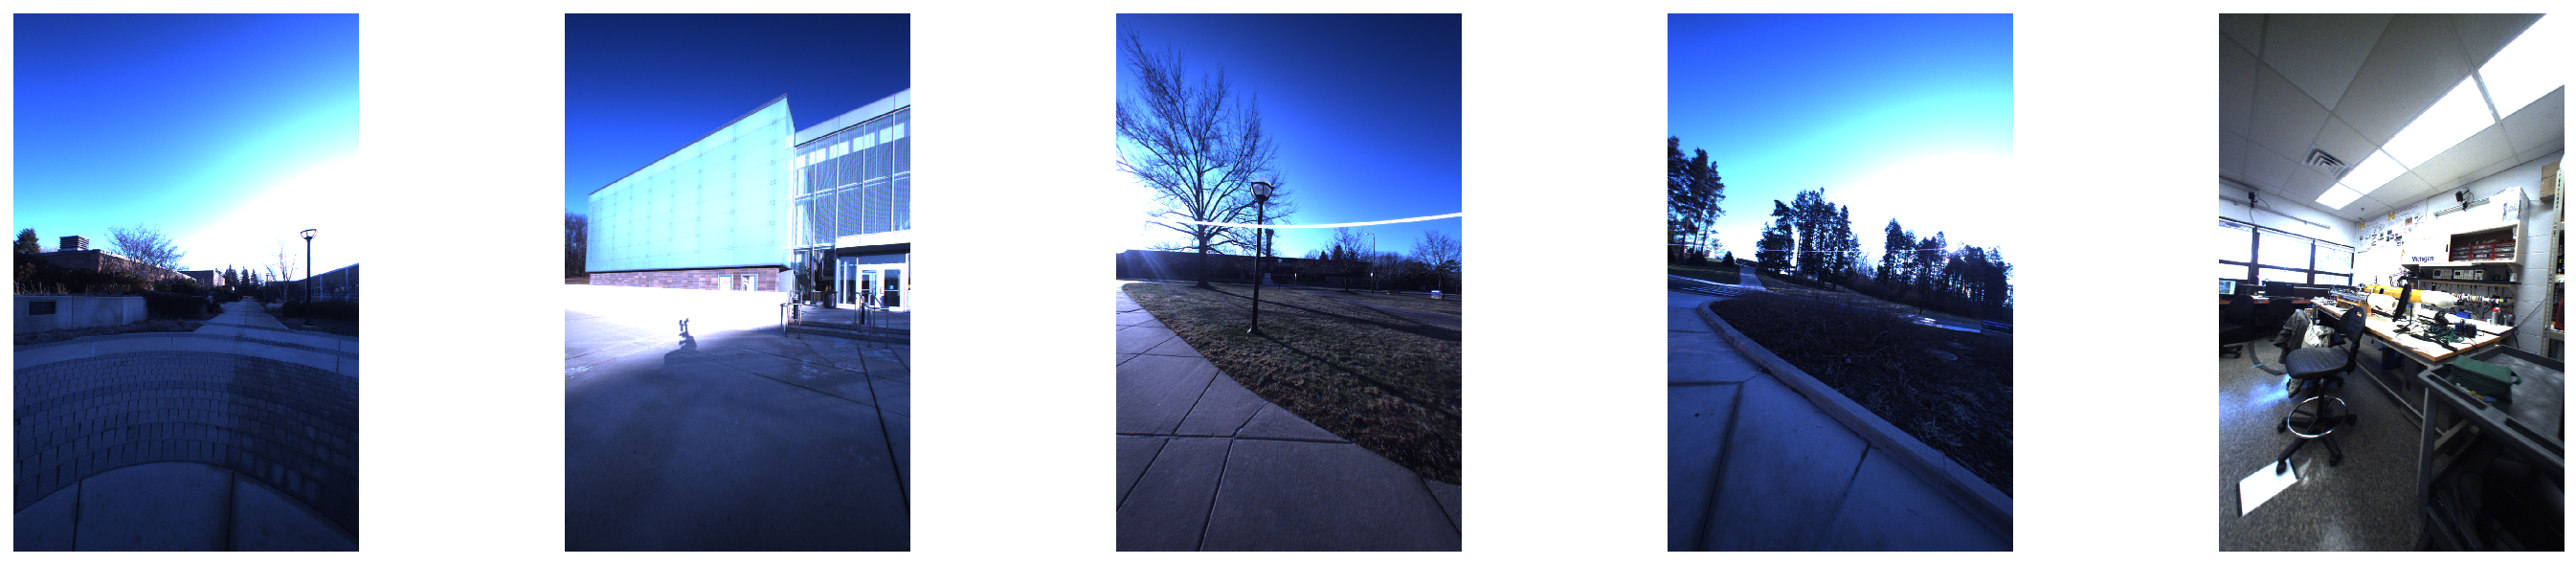

In [9]:
plot_imgs([imread(im_list[im_idx[i]]) for i in np.linspace(0, len(keypoints)-1, num=5, dtype=np.int)])

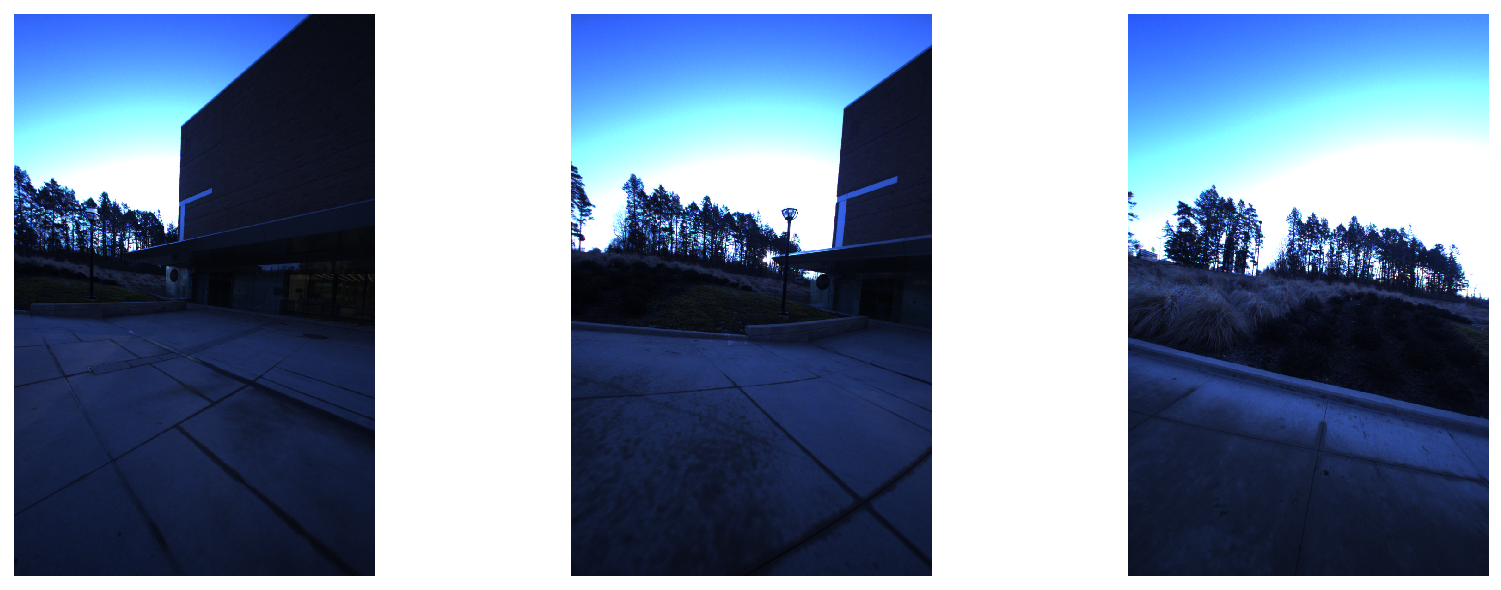

In [10]:
plot_imgs([imread(im_list[im_idx[i]]) for i in [100, 101, 102]])

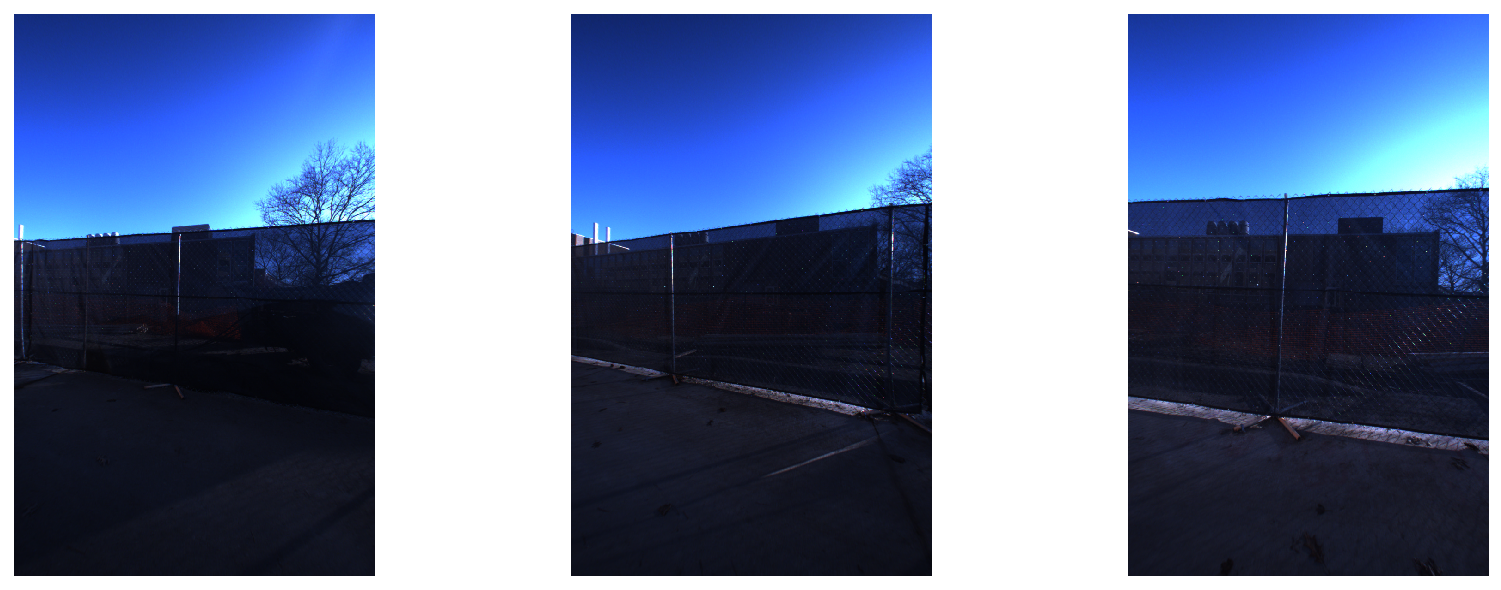

In [11]:
plot_imgs([imread(im_list[im_idx[i]]) for i in [800, 801, 802]])

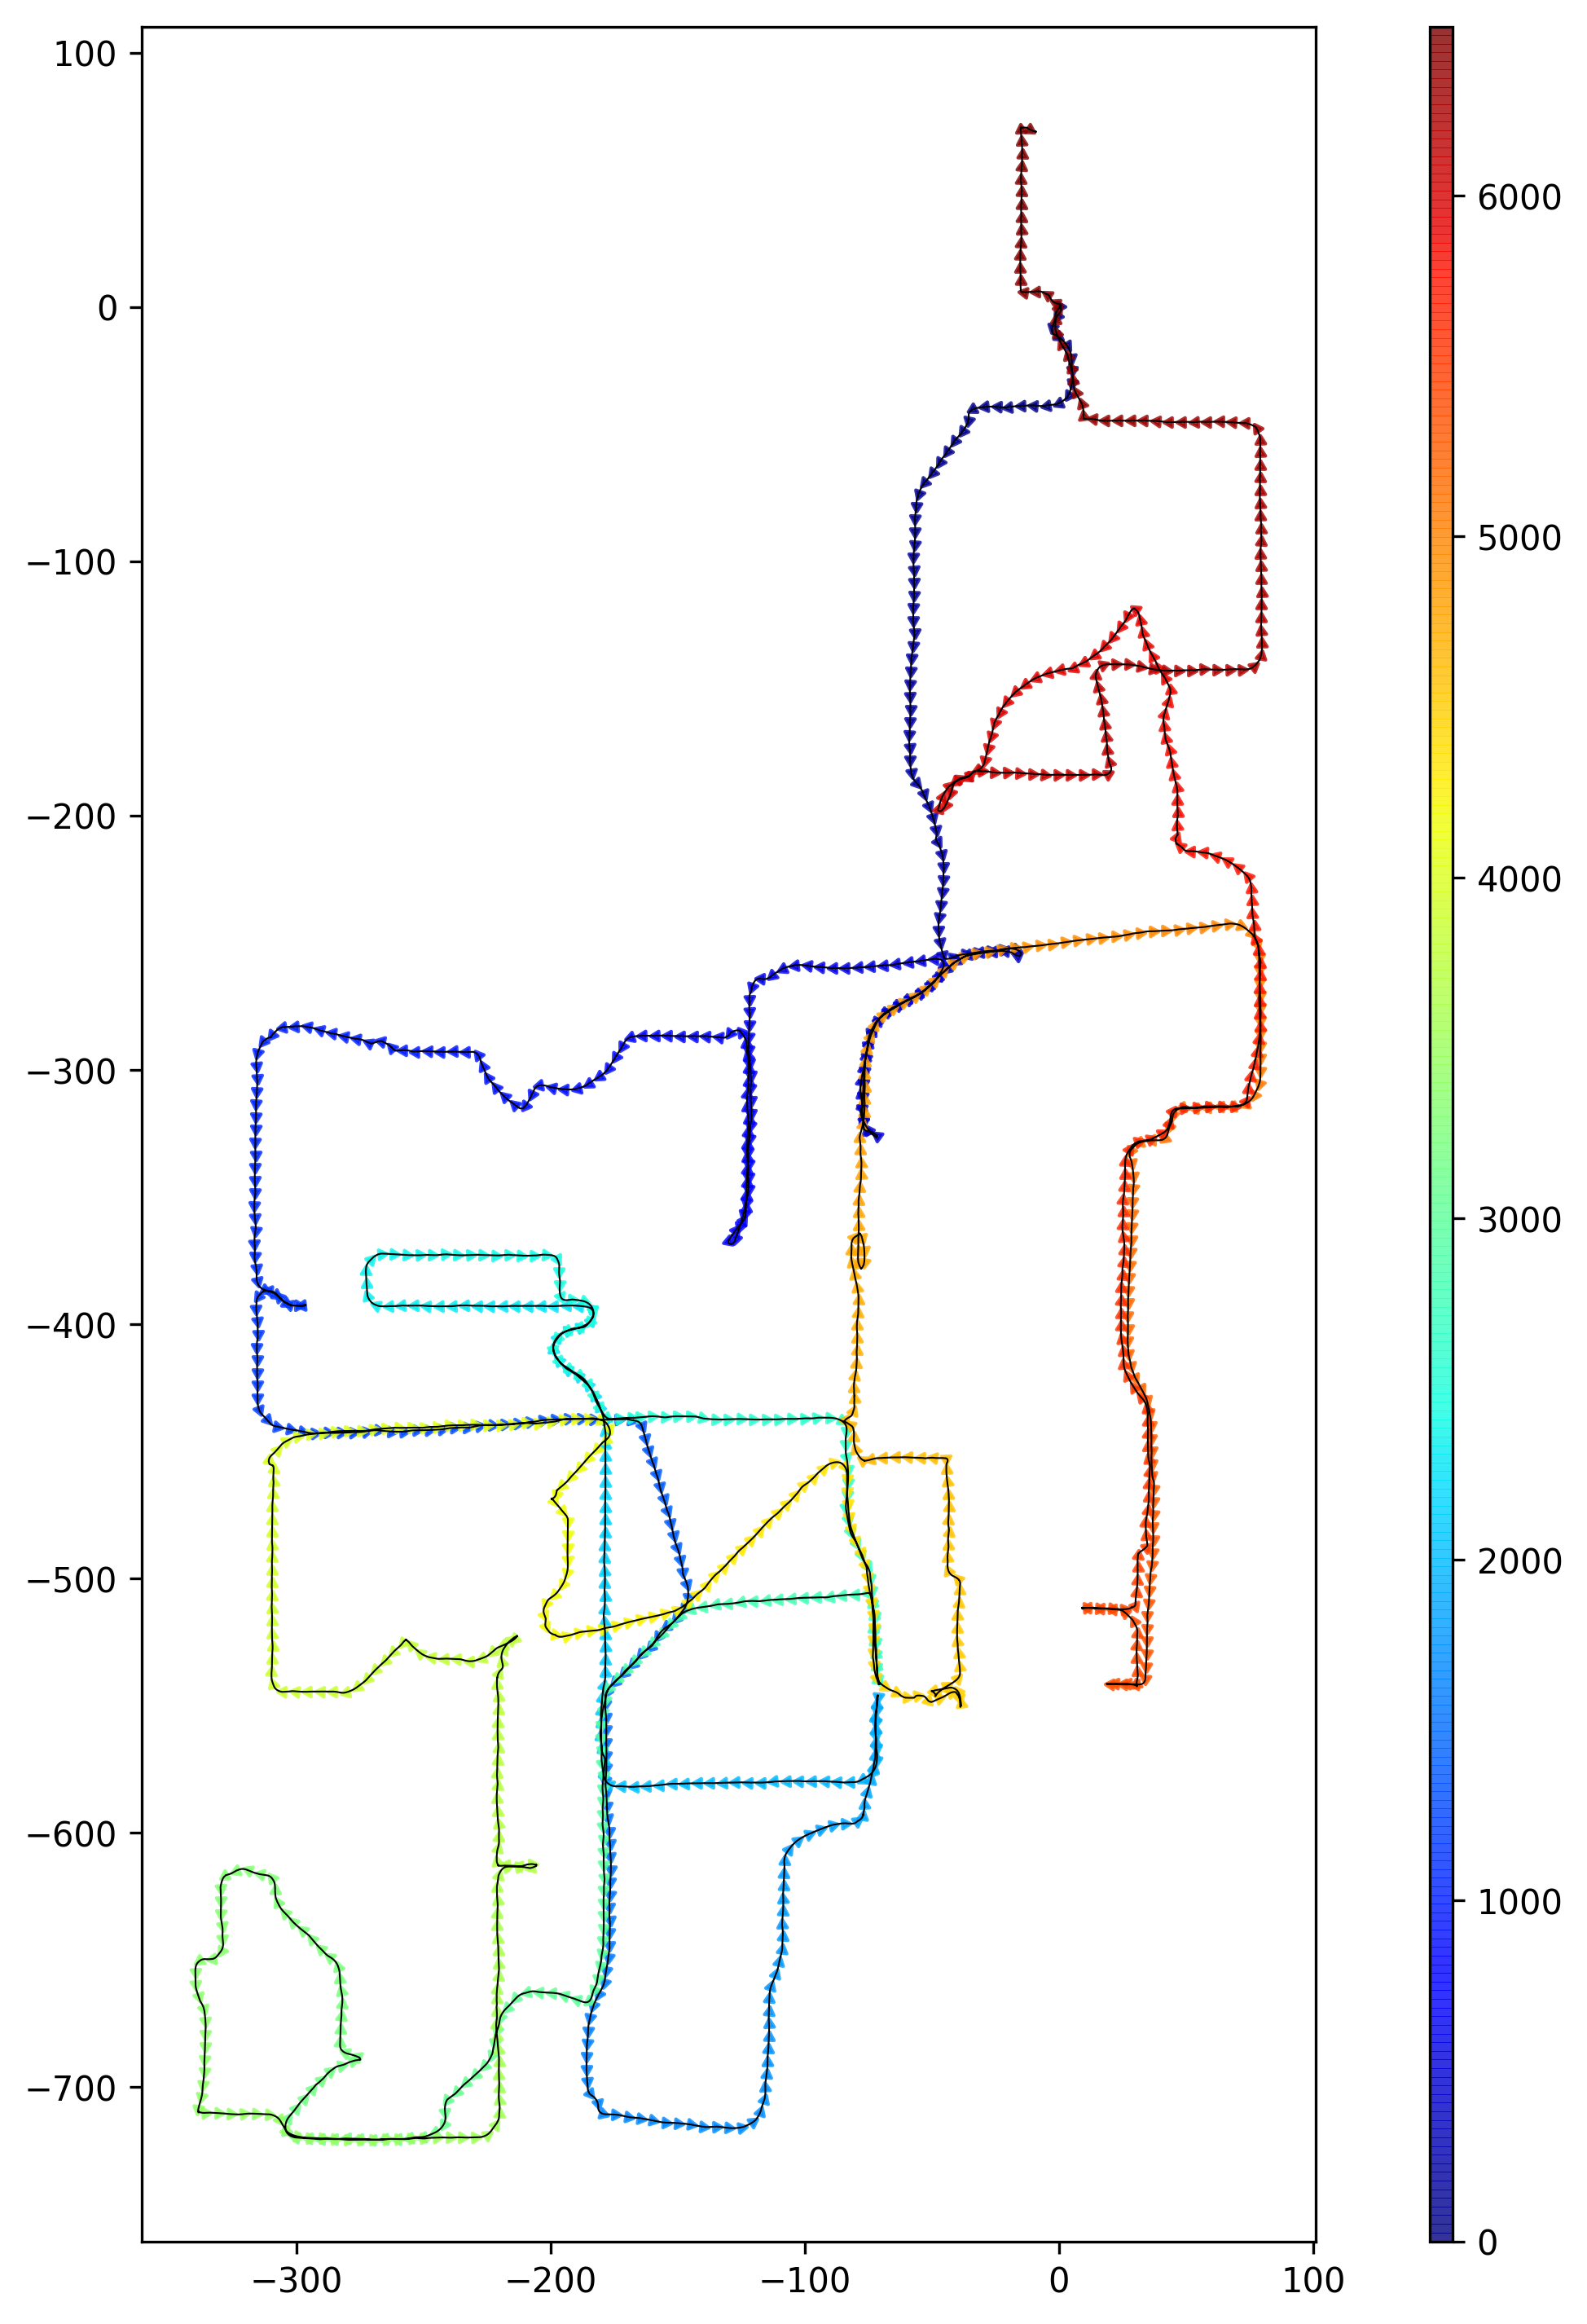

In [12]:
plt.figure(figsize=(12, 12), dpi=300)
plt.plot(gt_x, gt_y, linewidth=0.5, color='k');
plt.axes().set_aspect('equal')
for i, idx in enumerate(gt_idx):
    plt.scatter(gt_x[idx], gt_y[idx], linestyle = 'None', c=[keypoints[i]], cmap='jet', s=10,
                marker=(3, 1, 180*gt_angle[idx]/np.pi-90), alpha=0.8,
                norm=plt.Normalize(vmin=0, vmax=np.max(keypoints)));
plt.colorbar(use_gridspec=True, aspect=95);

In [ ]:
np.savetxt(root+'pose_{}.csv'.format(seq),
           np.rec.fromarrays((np.array(im_list, dtype=np.int)[im_idx], gt_x[gt_idx], gt_y[gt_idx], gt_angle[gt_idx])),
           delimiter=',',
           fmt='%i, %.15f, %.15f, %.15f',
           header='time, pose_x, pose_y, pose_angle')